In [1]:
# Import libraries
import pandas as pd
import numpy as np

# Modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import category_encoders as ce

# Metrics and graphics libraries
from sklearn import metrics
import seaborn as sn
from matplotlib import pyplot
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the raw data
plays_df = pd.read_csv('/Users/JKMacBook/Documents/Lambda/Kaggle/NFL/nfl-big-data-bowl-2021/full_play_3.csv')

In [3]:
# Select features
df = plays_df[['quarter', 'down', 'yardsToGo', 'yardlineNumber', 'defendersInTheBox',
               'numberOfPassRushers', 'manZone', 'scheme', 'route', 'endDist', 'covDist', 
               'closeSpeed', 'passResult']].copy()
df.head()

,quarter,down,yardsToGo,yardlineNumber,defendersInTheBox,numberOfPassRushers,manZone,scheme,route,endDist,covDist,closeSpeed,passResult
0,1,1,15,20,7.0,4.0,zone,cover-3,HITCH,2.957871,10.726609,4.369544,C
1,1,1,10,39,7.0,4.0,zone,cover-3,HITCH,1.891719,6.238350,4.909824,I
2,1,2,10,39,6.0,4.0,man,cover-1,NaN,NaN,NaN,NaN,I
3,1,3,10,39,6.0,5.0,man,cover-1,CORNER,3.898949,16.873620,5.341803,C
4,1,3,1,1,8.0,6.0,man,cover-0,GO,4.464135,5.517937,-3.789258,I


In [4]:
df.isnull().sum()

quarter                   0
down                      0
yardsToGo                 0
yardlineNumber            0
defendersInTheBox        62
numberOfPassRushers     633
manZone                   0
scheme                    0
route                  6216
endDist                6216
covDist                6298
closeSpeed             6298
passResult                2
dtype: int64

In [5]:
# Shape of the initial data
df.shape

(19239, 13)

In [6]:
values = {'defendersInTheBox': 7, 'route': 'None', 'passResult': 'I'}
df = df.fillna(value=values)
df = df.fillna(df.mean())

In [7]:
df.isnull().sum()

quarter                0
down                   0
yardsToGo              0
yardlineNumber         0
defendersInTheBox      0
numberOfPassRushers    0
manZone                0
scheme                 0
route                  0
endDist                0
covDist                0
closeSpeed             0
passResult             0
dtype: int64

In [8]:
# Shape after clean up
df.shape

(19239, 13)

In [9]:
# Encode target, Completions = 1, Incompletions, Interception and Sacks = 0
df['outcome'] = np.where(df['passResult'] == 'C', 1, 0)
df = df.drop(columns=['passResult'])
df.head()

,quarter,down,yardsToGo,yardlineNumber,defendersInTheBox,numberOfPassRushers,manZone,scheme,route,endDist,covDist,closeSpeed,outcome
0,1,1,15,20,7.0,4.0,zone,cover-3,HITCH,2.957871,10.726609,4.369544,1
1,1,1,10,39,7.0,4.0,zone,cover-3,HITCH,1.891719,6.238350,4.909824,0
2,1,2,10,39,6.0,4.0,man,cover-1,None,3.731315,8.635470,1.448355,0
3,1,3,10,39,6.0,5.0,man,cover-1,CORNER,3.898949,16.873620,5.341803,1
4,1,3,1,1,8.0,6.0,man,cover-0,GO,4.464135,5.517937,-3.789258,0


In [10]:
# Split into train and test
train, test = train_test_split(df, test_size=0.2)

In [11]:
# Test data completions vs incompletions
test['outcome'].value_counts()

1    2316
0    1532
Name: outcome, dtype: int64

In [12]:
# Encode and fit a Logistic Regression model
target = 'outcome'

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Create the pipeline
pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True), 
                         LogisticRegression())

# Fit the model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Print the confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1060,  472],
       [ 219, 2097]])

In [13]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8204261954261954
Precision: 0.8162709225379525
Recall: 0.905440414507772


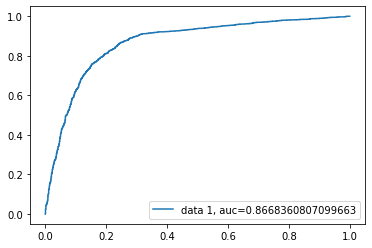

In [14]:
# Print the ROC curve
y_pred_proba = pipeline.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [15]:
# Obtain the feature coefficients
importance = pipeline.steps[1][1].coef_[0]
importance[0]

-0.020407974538429532

quarter  Score:  -0.020407974538429532
down  Score:  -0.09595930651635369
yardsToGo  Score:  -0.004892139210581285
yardlineNumber  Score:  0.0011433899020951493
defendersInTheBox  Score:  0.005825521930292497
numberOfPassRushers  Score:  -0.08863581116465494
manZone_man  Score:  0.23405850227840222
manZone_zone  Score:  0.1882370663987994
manZone_None  Score:  0.1506547020018582
scheme_cover-1  Score:  0.07699595312343459
scheme_cover-3  Score:  0.07355618485373715
scheme_cover-0  Score:  -0.12714130202555035
scheme_cover-4  Score:  0.11468088154481308
scheme_None  Score:  0.1506547020018582
scheme_cover-2  Score:  0.28420385118058966
route_FLAT  Score:  0.3505966006668746
route_CROSS  Score:  0.3213887186507643
route_HITCH  Score:  0.5615590010971391
route_None  Score:  -3.021875633645146
route_POST  Score:  -0.11194525813449455
route_GO  Score:  -0.3237497296073679
route_SLANT  Score:  0.45262352902087677
route_ANGLE  Score:  0.276799032592262
route_CORNER  Score:  -0.032749298621053

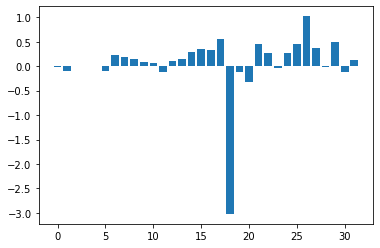

In [16]:
# Map the features to their coefficients
feature_names = pipeline.steps[0][1].get_feature_names()
for i in range(len(feature_names)):
    print(feature_names[i], ' Score: ', importance[i])
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()